## Homework

> Note: sometimes your answer doesn't match one of
> the options exactly. That's fine.
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

print("=== DATA PREPARATION ===")

# Load and examine data
df = pd.read_csv("course_lead_scoring.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nTarget variable distribution:")
print(df['converted'].value_counts())

# Check for missing values
print(f"\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Handle missing values
print("\nHandling missing values...")

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = ['lead_source', 'industry', 'employment_status', 'location']
numerical_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
# Remove target from lists if present
if 'converted' in numerical_cols:
    numerical_cols.remove('converted')
if 'converted' in categorical_cols:
    categorical_cols.remove('converted')

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Fill missing values
for col in categorical_cols:
    df[col] = df[col].fillna('NA')

for col in numerical_cols:
    df[col] = df[col].fillna(0.0)

print("Missing values after handling:")
print(df.isnull().sum().sum())

# Split data
print("\n=== DATA SPLITTING ===")

# First split: 60% train, 40% temp
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1, stratify=df['converted'])

# Second split: 20% validation, 20% test (from the 40% temp)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1, stratify=df_temp['converted'])
df_full_train = pd.concat([df_train, df_val])


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)



=== DATA PREPARATION ===
Dataset shape: (1462, 9)

Columns: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']

Target variable distribution:
converted
1    905
0    557
Name: count, dtype: int64

Missing values per column:
lead_source          128
industry             134
annual_income        181
employment_status    100
location              63
dtype: int64

Handling missing values...
Numerical columns: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
Categorical columns: ['lead_source', 'industry', 'employment_status', 'location']
Missing values after handling:
0

=== DATA SPLITTING ===



### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`


In [20]:
print("\n=== QUESTION 1: ROC AUC FEATURE IMPORTANCE ===")

y_train = df_train['converted'].values

# Check which numerical columns we have
target_numerical_cols = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
available_cols = [col for col in target_numerical_cols if col in df_train.columns]
print(f"Available numerical columns from the list: {available_cols}")

# If the exact column names don't exist, let's see what we have
print(f"All numerical columns in dataset: {[col for col in df_train.columns if df_train[col].dtype in ['int64', 'float64'] and col != 'converted']}")

# Calculate AUC for each numerical variable
auc_scores = {}

for col in numerical_cols:
    if col in df_train.columns:
        X_col = df_train[col].values
        auc = roc_auc_score(y_train, X_col)

        # If AUC < 0.5, invert the variable
        if auc < 0.5:
            auc = roc_auc_score(y_train, -X_col)
            print(f"{col}: AUC = {auc:.4f} (inverted)")
        else:
            print(f"{col}: AUC = {auc:.4f}")

        auc_scores[col] = auc

# Find the column with highest AUC among the target columns
target_aucs = {col: auc_scores.get(col, 0) for col in target_numerical_cols if col in auc_scores}
if target_aucs:
    best_feature = max(target_aucs, key=target_aucs.get)
    print(f"\nHighest AUC among target features: {best_feature} with AUC = {target_aucs[best_feature]:.4f}")



=== QUESTION 1: ROC AUC FEATURE IMPORTANCE ===
Available numerical columns from the list: ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
All numerical columns in dataset: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
number_of_courses_viewed: AUC = 0.7636
annual_income: AUC = 0.5520
interaction_count: AUC = 0.7383
lead_score: AUC = 0.6145

Highest AUC among target features: number_of_courses_viewed with AUC = 0.7636



### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92



In [21]:
print("\n=== QUESTION 2: TRAINING THE MODEL ===")

# Prepare data for training
def prepare_data(df):
    # Convert to dictionary format for DictVectorizer
    df_dict = df[categorical_cols + numerical_cols].to_dict(orient='records')
    return df_dict

# Prepare training and validation data
train_dicts = prepare_data(df_train)
val_dicts = prepare_data(df_val)

y_train = df_train['converted'].values
y_val = df_val['converted'].values

# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Evaluate on validation set
y_pred_val = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred_val)

print(f"Validation AUC: {auc_val:.3f}")


=== QUESTION 2: TRAINING THE MODEL ===
Training features shape: (876, 31)
Validation features shape: (293, 31)
Validation AUC: 0.817



### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745




=== QUESTION 3: PRECISION AND RECALL ===


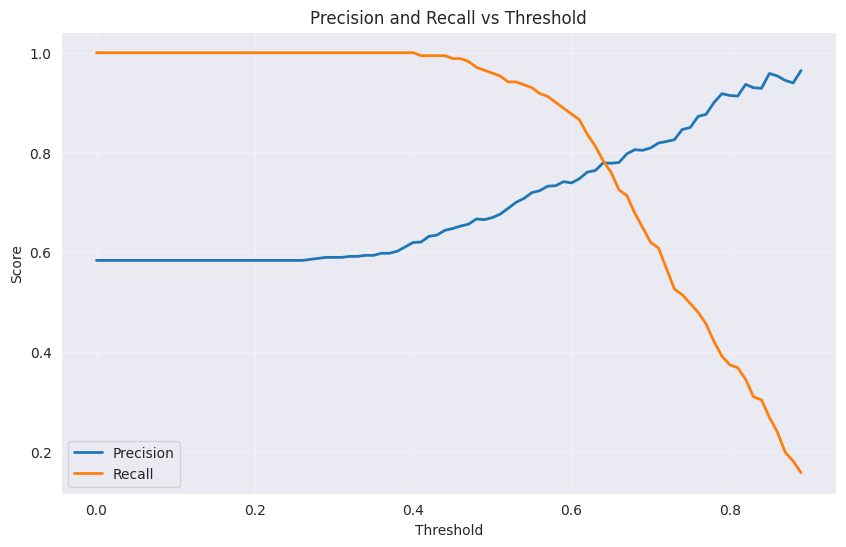

Precision and Recall curves intersect at threshold: 0.640


In [22]:
print("\n=== QUESTION 3: PRECISION AND RECALL ===")

# Calculate precision and recall for different thresholds
thresholds = np.arange(0.0, 0.9, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_binary = (y_pred_val >= threshold).astype(int)

    # Calculate precision and recall manually
    tp = np.sum((y_pred_binary == 1) & (y_val == 1))
    fp = np.sum((y_pred_binary == 1) & (y_val == 0))
    fn = np.sum((y_pred_binary == 0) & (y_val == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find intersection point
differences = np.abs(np.array(precisions) - np.array(recalls))
intersection_idx = np.argmin(differences)
intersection_threshold = thresholds[intersection_idx]

print(f"Precision and Recall curves intersect at threshold: {intersection_threshold:.3f}")



### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74




=== QUESTION 4: F1 SCORE ===
Maximum F1 score: 0.8125 at threshold: 0.57


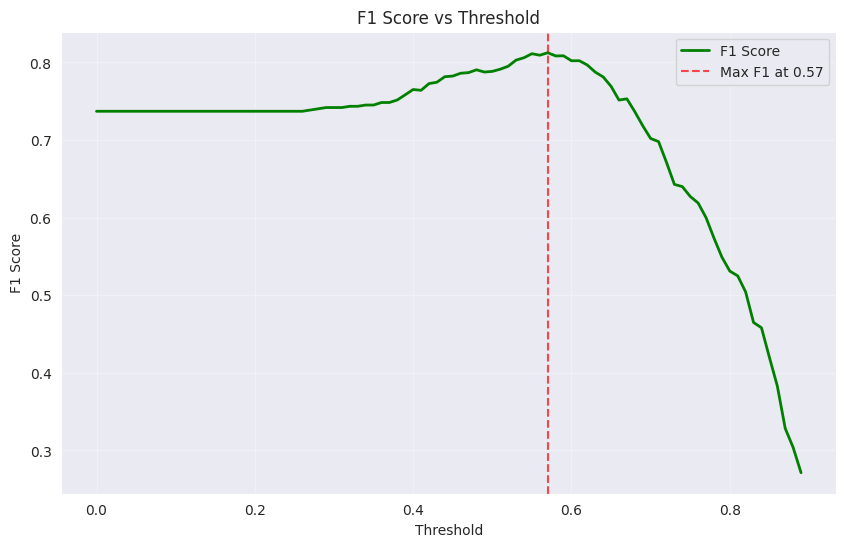

In [23]:
print("\n=== QUESTION 4: F1 SCORE ===")

# Calculate F1 scores
f1_scores = []

for i in range(len(precisions)):
    p, r = precisions[i], recalls[i]
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)

# Find maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_score:.4f} at threshold: {max_f1_threshold:.2f}")

# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='green')
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', alpha=0.7, label=f'Max F1 at {max_f1_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36



In [24]:
print("\n=== QUESTION 5: 5-FOLD CV ===")

# Prepare full training data
full_train_dicts = prepare_data(df_full_train)
y_full_train = df_full_train['converted'].values

# 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
    # Split data
    df_fold_train = df_full_train.iloc[train_idx]
    df_fold_val = df_full_train.iloc[val_idx]

    # Prepare data
    fold_train_dicts = prepare_data(df_fold_train)
    fold_val_dicts = prepare_data(df_fold_val)

    y_fold_train = df_fold_train['converted'].values
    y_fold_val = df_fold_val['converted'].values

    # Transform data
    dv_fold = DictVectorizer(sparse=False)
    X_fold_train = dv_fold.fit_transform(fold_train_dicts)
    X_fold_val = dv_fold.transform(fold_val_dicts)

    # Train model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_fold_train, y_fold_train)

    # Evaluate
    y_pred_fold = model_fold.predict_proba(X_fold_val)[:, 1]
    auc_fold = roc_auc_score(y_fold_val, y_pred_fold)
    cv_scores.append(auc_fold)

    print(f"Fold {fold + 1}: AUC = {auc_fold:.4f}")

cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"\nCross-validation results:")
print(f"Mean AUC: {cv_mean:.4f}")
print(f"Standard deviation: {cv_std:.4f}")



=== QUESTION 5: 5-FOLD CV ===
Fold 1: AUC = 0.8061
Fold 2: AUC = 0.8714
Fold 3: AUC = 0.7754
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558

Cross-validation results:
Mean AUC: 0.8221
Standard deviation: 0.0358



### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [25]:
print("\n=== QUESTION 6: HYPERPARAMETER TUNING ===")

C_values = [0.000001, 0.001, 1]
results = {}

for C in C_values:
    print(f"\nTesting C = {C}")
    cv_scores_c = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
        # Split data
        df_fold_train = df_full_train.iloc[train_idx]
        df_fold_val = df_full_train.iloc[val_idx]

        # Prepare data
        fold_train_dicts = prepare_data(df_fold_train)
        fold_val_dicts = prepare_data(df_fold_val)

        y_fold_train = df_fold_train['converted'].values
        y_fold_val = df_fold_val['converted'].values

        # Transform data
        dv_fold = DictVectorizer(sparse=False)
        X_fold_train = dv_fold.fit_transform(fold_train_dicts)
        X_fold_val = dv_fold.transform(fold_val_dicts)

        # Train model with specific C
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_fold_train, y_fold_train)

        # Evaluate
        y_pred_fold = model_fold.predict_proba(X_fold_val)[:, 1]
        auc_fold = roc_auc_score(y_fold_val, y_pred_fold)
        cv_scores_c.append(auc_fold)

    mean_score = np.mean(cv_scores_c)
    std_score = np.std(cv_scores_c)
    results[C] = {'mean': mean_score, 'std': std_score}

    print(f"C = {C}: Mean = {mean_score:.3f}, Std = {std_score:.3f}")

print("\n=== HYPERPARAMETER TUNING RESULTS ===")
for C, result in results.items():
    print(f"C = {C}: Mean = {result['mean']:.3f}, Std = {result['std']:.3f}")

# Find best C
best_mean = max(results.values(), key=lambda x: x['mean'])['mean']
best_candidates = [C for C, result in results.items() if result['mean'] == best_mean]

if len(best_candidates) == 1:
    best_C = best_candidates[0]
else:
    # If tie in mean, select lowest std
    best_std = min([results[C]['std'] for C in best_candidates])
    best_candidates = [C for C in best_candidates if results[C]['std'] == best_std]

    if len(best_candidates) == 1:
        best_C = best_candidates[0]
    else:
        # If still tie, select smallest C
        best_C = min(best_candidates)

print(f"\nBest C: {best_C}")


=== QUESTION 6: HYPERPARAMETER TUNING ===

Testing C = 1e-06
C = 1e-06: Mean = 0.560, Std = 0.024

Testing C = 0.001
C = 0.001: Mean = 0.867, Std = 0.029

Testing C = 1
C = 1: Mean = 0.822, Std = 0.036

=== HYPERPARAMETER TUNING RESULTS ===
C = 1e-06: Mean = 0.560, Std = 0.024
C = 0.001: Mean = 0.867, Std = 0.029
C = 1: Mean = 0.822, Std = 0.036

Best C: 0.001



## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one
